# Analiza opinii z Twittera

- [Wstęp](#wstęp)
- [Preprocessing](#preprocessing)
- [Analiza Opinii](#analiza-opinii)
    - [Analiza Całościowa](#analiza-calosciowa)
    - [Analiza Czasowa](#analiza-czasowa)
- [Podsumowanie](#podsumowanie)
- [Bibliografia](#bibliografia)

<h2 id="wstep">Wstęp</h2>

Tematem pracy jest analiza opinii z Twittera na podstawie wybranego hashtagu, w tym konkretnej pracy wykorzystano hashtag **#premierleague** do badania opinii na temat angielskiej ligi Premier League. Baza obejmuje ponad 10000 tweetów powiązanych z tym tematem, pobierano 250 tweetów co miesiąc, przez ostatnie 4 lata, z uwagi na "sezonowość" ligi piłkarskiej. Użyto narzędzia **snscrape** do pobierania tweetów i zapisania ich do pliku **tweets.csv**.

In [17]:
import datetime
import csv
import snscrape.modules.twitter as sntwitter

def get_tweets(hashtag, num_tweets):
    tweets = []

    today = datetime.date.today()
    four_years_ago = today - datetime.timedelta(days=365 * 4)

    current_date = today
    while current_date > four_years_ago:
        start_date = datetime.date(current_date.year, current_date.month, 1)
        end_date = current_date

        start_date_str = start_date.strftime('%Y-%m-%d')
        end_date_str = end_date.strftime('%Y-%m-%d')

        query = f'#{hashtag} since:{start_date_str} until:{end_date_str}'

        month_tweets = []
        for tweet in sntwitter.TwitterHashtagScraper(query).get_items():
            date_str = str(tweet.date)
            date_part = date_str.split()
            month_tweets.append({
                'Content': str(tweet.rawContent).replace('\n', ''),
                'Date': date_part[0],
                'Lang': tweet.lang
            })

            if len(month_tweets) >= num_tweets:
                break

        tweets = month_tweets + tweets

        current_date = datetime.date(current_date.year, current_date.month, 1) - datetime.timedelta(days=1)

    with open('tweets.csv', 'w', encoding='utf-8', newline='') as file:
        fieldnames = ['Content', 'Date', 'Lang']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for tweet in tweets:
            writer.writerow(tweet)

    print("Pomyślnie zapisano tweety do pliku tweets.csv!")

hashtag = 'premierleague'
num_tweets = 250

get_tweets(hashtag, num_tweets)


Stopping after 20 empty pages
Unavailable user in card on tweet 1652449917510594561
Unavailable user in card on tweet 1652449917510594561
User 819188347314851843 not found in user refs in card on tweet 1652449917510594561
User 819188347314851843 not found in user refs in card on tweet 1652449917510594561
Unavailable user in card on tweet 1652447515256520704
Unavailable user in card on tweet 1652447515256520704
User 819188347314851843 not found in user refs in card on tweet 1652447515256520704
User 819188347314851843 not found in user refs in card on tweet 1652447515256520704
Unavailable user in card on tweet 1608974727170908160
User 1041604336160137216 not found in user refs in card on tweet 1608974727170908160
Unavailable user in card on tweet 1575633282439315457
User 1240203163 not found in user refs in card on tweet 1575633282439315457
Unavailable user in card on tweet 1575633265829953536
User 1240203163 not found in user refs in card on tweet 1575633265829953536
Unavailable user in

Pomyślnie zapisano tweety do pliku tweets.csv!


Do pliku csv jest zapisywany rawContent tweeta, czyli jego treść, data publikacja tweeta przeformatowana na ujednolicony format oraz język, w którym został napisany dany tweet.

<h2 id="preprocessing">Preprocessing</h2>

Przed przeprowadzeniem analizy opinii, konieczna jest obróbka pobranych tweetów. Tweety zostały przetłumaczone na angielski z użyciem **googletrans**. Zostały również dodane wyjątki w przypadku niektórych skrajnych i niespotykanych języków. Przetłumaczone tweety zostały zapisane do pliku **translated_tweets.csv**.

In [18]:
from googletrans import Translator

def translate_tweets():
    translated_tweets = []

    with open('tweets.csv', 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        translated_tweet = ''
        for row in reader:
            translator = Translator(service_urls=['translate.googleapis.com'])
            tweet_content = row['Content']
            lang = row['Lang']

            if lang != 'en':
                if lang == 'in':
                    translated_tweet = translator.translate(tweet_content, dest='en', src='es').text
                elif lang == 'zh':
                    translated_tweet = translator.translate(tweet_content, dest='en', src='zh-cn').text
                elif lang not in ['zxx', 'und', 'qme', 'qht', 'qst', 'qam']:
                    translated_tweet = translator.translate(tweet_content, dest='en', src=lang).text
            else:
                translated_tweet = tweet_content

            translated_tweets.append({'TranslatedContent': translated_tweet, 'Date': row['Date']})

    with open('translated_tweets.csv', 'w', encoding='utf-8', newline='') as file:
        fieldnames = ['TranslatedContent', 'Date']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for tweet in translated_tweets:
            writer.writerow(tweet)

    print('Przetłumaczone tweety zostały zapisane do pliku translated_tweets.csv!')

translate_tweets()


Przetłumaczone tweety zostały zapisane do pliku translated_tweets.csv!


Po przetłumaczeniu tweetów wszystkie słowa są zapisywane małymi literami, usunięto znaki niebędący literami ani spacjami, oraz użytkowników na podstawie znaku `@` przed ich nazwami. Następnie wykonano kroki dla Bag of Words, czyli tokenizację, stopwords i lematyzację. Do stopwords dodano słowa występujące w **#premierleague**. Tweety po preprocessingu zostały zapisane do pliku **preprocessing_tweets.csv**.

In [19]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)

    tokens = nltk.word_tokenize(tweet)
    tokens = [token for token in tokens if token.isalpha()]

    stop_words = set(stopwords.words('english'))
    stop_words.add('premier')
    stop_words.add('league')
    stop_words.add('premierleague')
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    preprocessed_tweet = ' '.join(tokens)
    return preprocessed_tweet

def preprocess_tweets():
    preprocessed_tweets = []

    with open('translated_tweets.csv', 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            translated_tweet = row['TranslatedContent']
            preprocessed_tweet = preprocess_tweet(translated_tweet)
            preprocessed_tweets.append({'PreprocessedContent': preprocessed_tweet, 'Date': row['Date']})

    with open('preprocessed_tweets.csv', 'w', encoding='utf-8', newline='') as file:
        fieldnames = ['PreprocessedContent', 'Date']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for tweet in preprocessed_tweets:
            writer.writerow(tweet)

    print('Przetworzone tweety zostały zapisane do pliku preprocessed_tweets.csv!')

preprocess_tweets()


Przetworzone tweety zostały zapisane do pliku preprocessed_tweets.csv!


<h2 id="analiza-opinii">Analiza opinii</h2>

Po preprocessingu można zacząć analizę opinii tweetów. W tym celu posłużą narzędzia do wykrywania emocji w tweetach oraz różne sposoby tego zobrazowania.

<br>

<h4 id="analiza-calosciowa">Analiza całościowa</h4>

W analizie całościowej tworzone są wykresy w postaci chmur słów, które w przyjemny dla oka sposób pokazują najcześciej występujące słowa w zależności od emocji przez większą lub mniejszą czcionkę. Tworzone są 3 chmurki, pierwsza - wszystkich tweetów, druga - tweetów pozytywnych, trzecia - tweetów negatywnych. Chmurki są tworzone przy użyciu **wordcloud**. Tweet z neutralnością powyżej 0.5 nie jest brany pod uwagę, tak samo, jak opinia której wartość pozytywna/negatywna nie przekroczy 0.5.


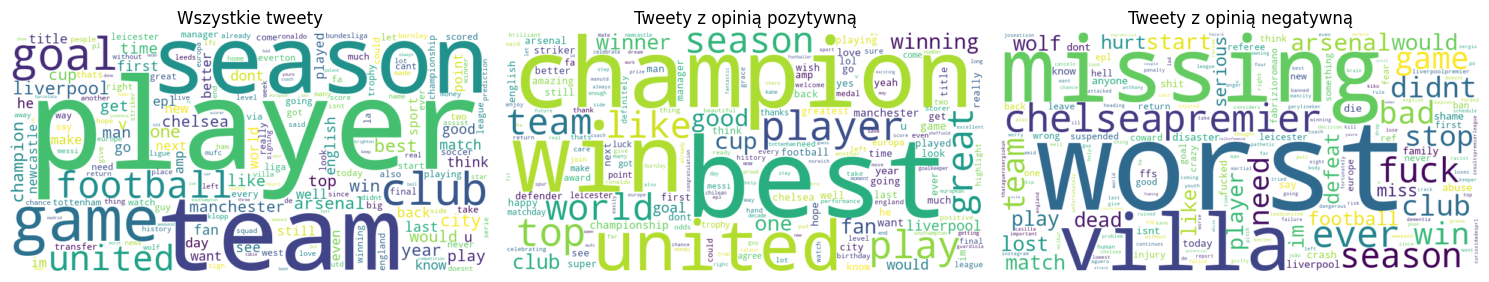

In [2]:
import csv
import matplotlib.pyplot as plt
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from text2emotion import get_emotion

tweets = []

with open('preprocessed_tweets.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        words = row['PreprocessedContent'].split()
        tweets.append(words)

analyzer = SentimentIntensityAnalyzer()
sentiments = [analyzer.polarity_scores(' '.join(tweet)) for tweet in tweets]

positive_tweets = [tweet for tweet, sentiment in zip(tweets, sentiments) if sentiment['pos'] > 0.5 > sentiment['neu'] and sentiment['pos'] > sentiment['neg']]
negative_tweets = [tweet for tweet, sentiment in zip(tweets, sentiments) if sentiment['neg'] > 0.5 > sentiment['neu'] and sentiment['neg'] > sentiment['pos']]

all_words = [word for tweet in tweets for word in tweet]
all_words_freq = FreqDist(all_words)
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(all_words_freq)

positive_words = [word for tweet in positive_tweets for word in tweet]
positive_words_freq = FreqDist(positive_words)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_words_freq)

negative_words = [word for tweet in negative_tweets for word in tweet]
negative_words_freq = FreqDist(negative_words)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_words_freq)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Wszystkie tweety')

plt.subplot(132)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Tweety z opinią pozytywną')

plt.subplot(133)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Tweety z opinią negatywną')

plt.tight_layout()
plt.show()


Chmurki dla 5 emocji **text2emotion** ('Happy', 'Sad', 'Angry', Fear', 'Surprise'):

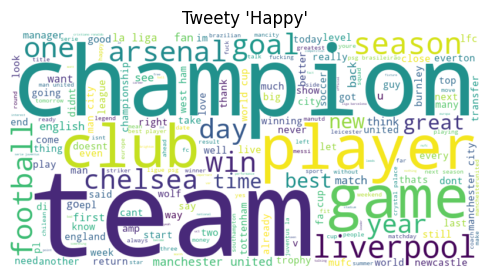

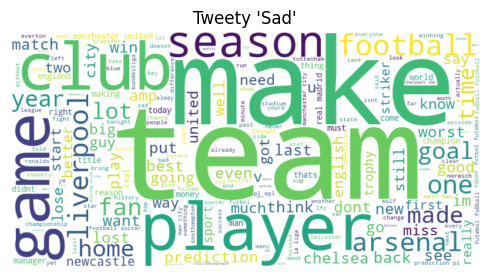

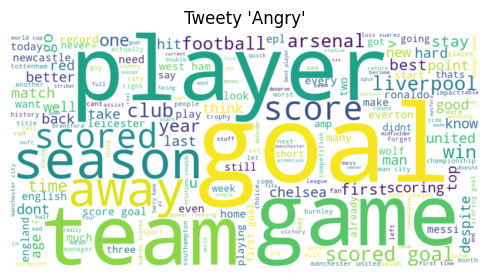

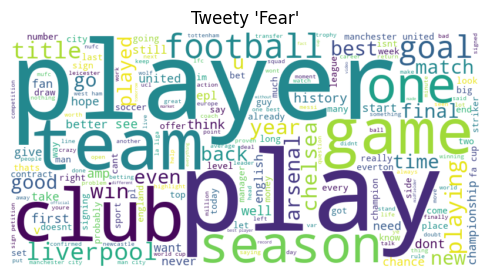

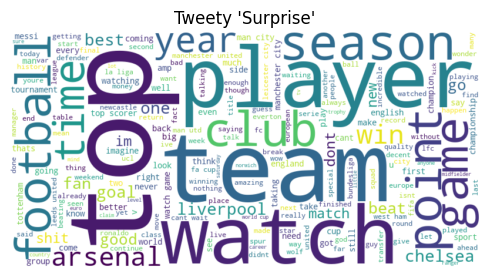

In [5]:
def word_clouds(tweets, name):
    plt.figure(figsize=(5, 5))
    wordcloud_text = ' '.join(tweets)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(name)

    plt.tight_layout()
    plt.show()

happy_tweets = []
sadness_tweets = []
anger_tweets = []
fear_tweets = []
surprise_tweets = []

for tweet in tweets:
    all_tweet = ""
    for word in tweet:
        all_tweet += word + " "
    emotions = get_emotion(all_tweet)

    dominant_emotion = max(emotions, key=emotions.get)

    if dominant_emotion == 'Happy':
        happy_tweets.append(all_tweet)
    elif dominant_emotion == 'Sad':
        sadness_tweets.append(all_tweet)
    elif dominant_emotion == 'Angry':
        anger_tweets.append(all_tweet)
    elif dominant_emotion == 'Fear':
        fear_tweets.append(all_tweet)
    elif dominant_emotion == 'Surprise':
        surprise_tweets.append(all_tweet)

word_clouds(happy_tweets,"Tweety 'Happy'")
word_clouds(sadness_tweets,"Tweety 'Sad'")
word_clouds(anger_tweets,"Tweety 'Angry'")
word_clouds(fear_tweets,"Tweety 'Fear'")
word_clouds(surprise_tweets,"Tweety 'Surprise'")


Dodatkowo wykonano wykresy słupkowe dla 10 najcześciej występujących słów w tweetach z opiniami pozytywnymi i negatywnymi oraz z emocjami text2emotion:

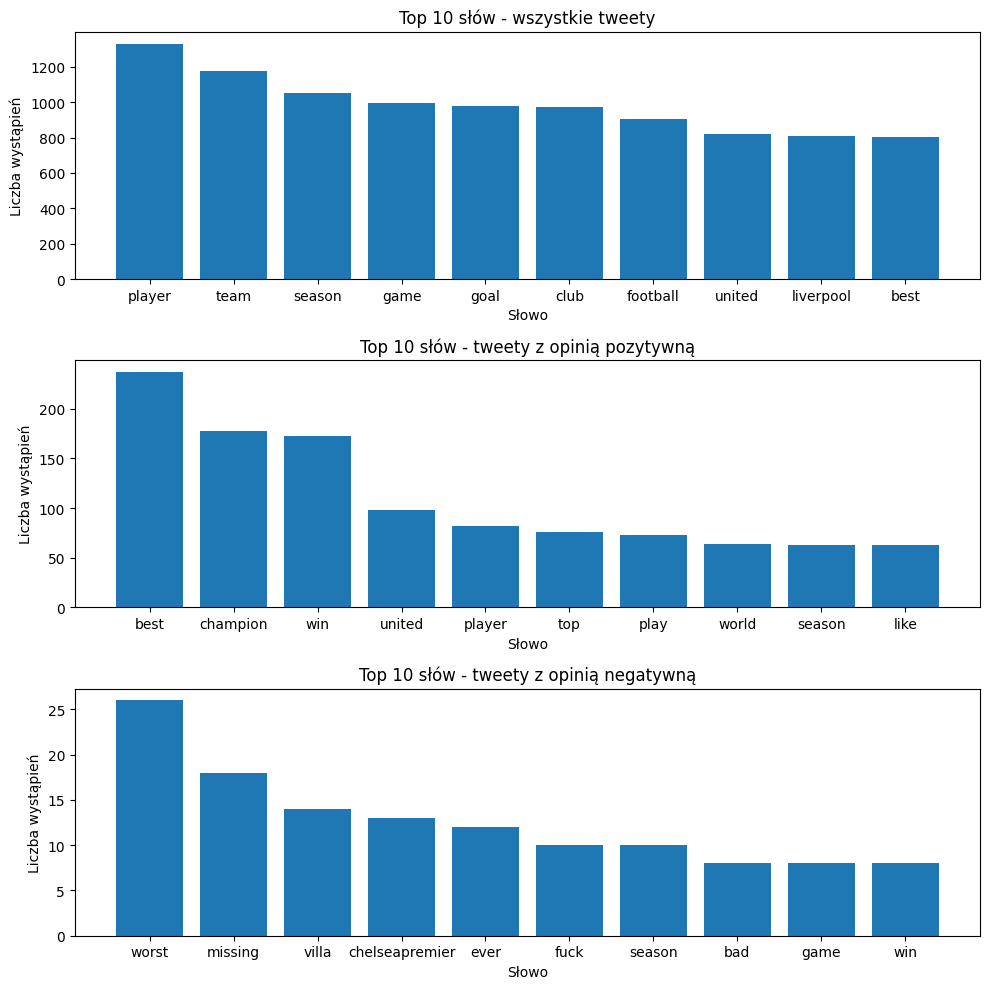

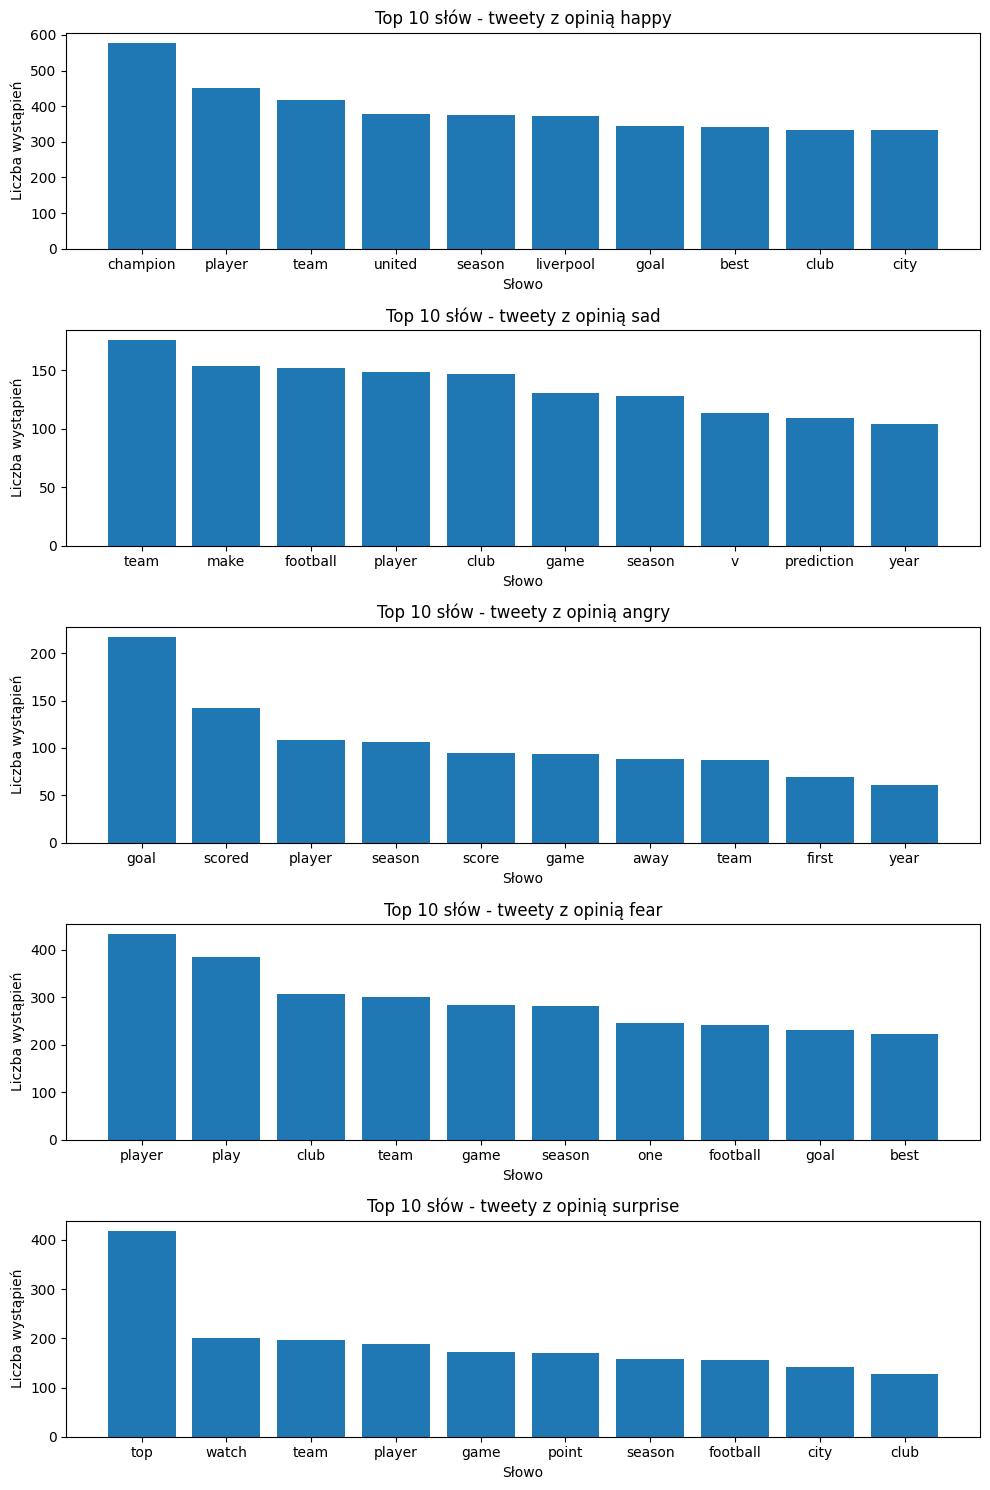

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

axes[0].bar(*zip(*all_words_freq.most_common(10)))
axes[0].set_title('Top 10 słów - wszystkie tweety')
axes[0].set_xlabel('Słowo')
axes[0].set_ylabel('Liczba wystąpień')

axes[1].bar(*zip(*positive_words_freq.most_common(10)))
axes[1].set_title('Top 10 słów - tweety z opinią pozytywną')
axes[1].set_xlabel('Słowo')
axes[1].set_ylabel('Liczba wystąpień')

axes[2].bar(*zip(*negative_words_freq.most_common(10)))
axes[2].set_title('Top 10 słów - tweety z opinią negatywną')
axes[2].set_xlabel('Słowo')
axes[2].set_ylabel('Liczba wystąpień')

plt.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

happy_words = [word for tweet in happy_tweets for word in tweet.split()]
happy_words_freq = FreqDist(happy_words)
axes2[0].bar(*zip(*happy_words_freq.most_common(10)))
axes2[0].set_title('Top 10 słów - tweety z opinią happy')
axes2[0].set_xlabel('Słowo')
axes2[0].set_ylabel('Liczba wystąpień')

sad_words = [word for tweet in sadness_tweets for word in tweet.split()]
sad_words_freq = FreqDist(sad_words)
axes2[1].bar(*zip(*sad_words_freq.most_common(10)))
axes2[1].set_title('Top 10 słów - tweety z opinią sad')
axes2[1].set_xlabel('Słowo')
axes2[1].set_ylabel('Liczba wystąpień')

angry_words = [word for tweet in anger_tweets for word in tweet.split()]
angry_words_freq = FreqDist(angry_words)
axes2[2].bar(*zip(*angry_words_freq.most_common(10)))
axes2[2].set_title('Top 10 słów - tweety z opinią angry')
axes2[2].set_xlabel('Słowo')
axes2[2].set_ylabel('Liczba wystąpień')

fear_words = [word for tweet in fear_tweets for word in tweet.split()]
fear_words_freq = FreqDist(fear_words)
axes2[3].bar(*zip(*fear_words_freq.most_common(10)))
axes2[3].set_title('Top 10 słów - tweety z opinią fear')
axes2[3].set_xlabel('Słowo')
axes2[3].set_ylabel('Liczba wystąpień')

surprise_words = [word for tweet in surprise_tweets for word in tweet.split()]
surprise_words_freq = FreqDist(surprise_words)
axes2[4].bar(*zip(*surprise_words_freq.most_common(10)))
axes2[4].set_title('Top 10 słów - tweety z opinią surprise')
axes2[4].set_xlabel('Słowo')
axes2[4].set_ylabel('Liczba wystąpień')

plt.tight_layout()
plt.show()

<h4 id="analiza-czasowa">Analiza czasowa</h4>

Analiza czasowa polega na narysowaniu wykresu liniowego. Tweety są dzielone na 5 emocji, które potem są rysowane jako linie na jednym wspólnym wykresie. W tym momencie przydatny jest podział zapisanych tweetów na 250 tweetów co miesiąc przez ostatnie 4 lata. Użyto biblioteki **text2emotion** do podziału emocji w tweetach.

Przetworzono emocje dla 200 tweetów
Przetworzono emocje dla 400 tweetów
Przetworzono emocje dla 600 tweetów
Przetworzono emocje dla 800 tweetów
Przetworzono emocje dla 1000 tweetów
Przetworzono emocje dla 1200 tweetów
Przetworzono emocje dla 1400 tweetów
Przetworzono emocje dla 1600 tweetów
Przetworzono emocje dla 1800 tweetów
Przetworzono emocje dla 2000 tweetów
Przetworzono emocje dla 2200 tweetów
Przetworzono emocje dla 2400 tweetów
Przetworzono emocje dla 2600 tweetów
Przetworzono emocje dla 2800 tweetów
Przetworzono emocje dla 3000 tweetów
Przetworzono emocje dla 3200 tweetów
Przetworzono emocje dla 3400 tweetów
Przetworzono emocje dla 3600 tweetów
Przetworzono emocje dla 3800 tweetów
Przetworzono emocje dla 4000 tweetów
Przetworzono emocje dla 4200 tweetów
Przetworzono emocje dla 4400 tweetów
Przetworzono emocje dla 4600 tweetów
Przetworzono emocje dla 4800 tweetów
Przetworzono emocje dla 5000 tweetów
Przetworzono emocje dla 5200 tweetów
Przetworzono emocje dla 5400 tweetów
Przet

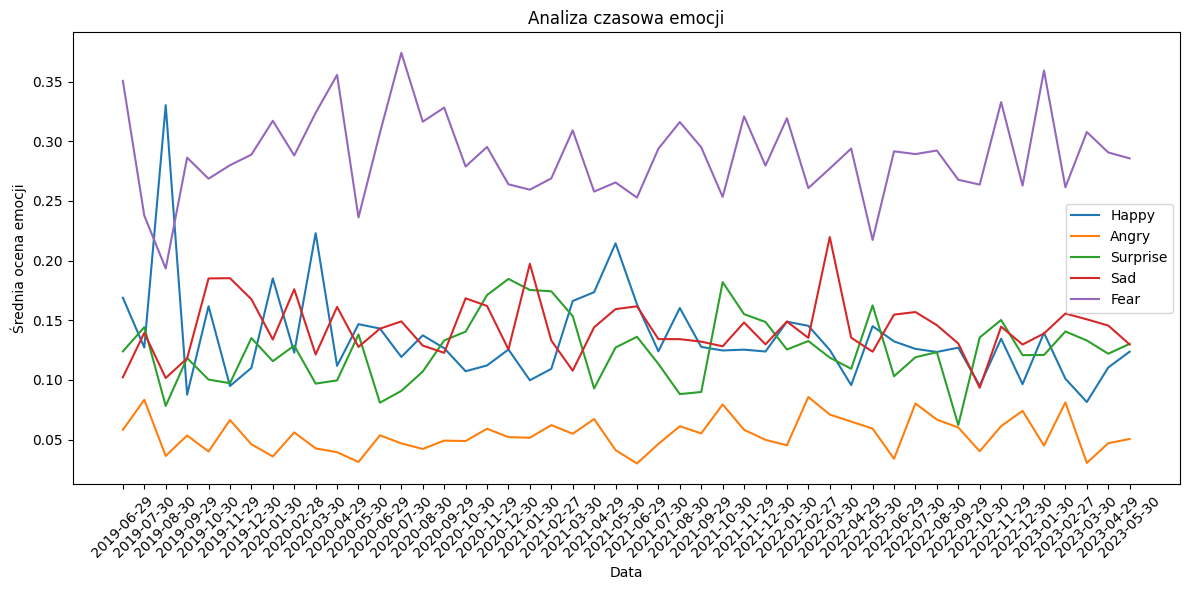

In [22]:
import csv
import matplotlib.pyplot as plt
from collections import defaultdict
from text2emotion import get_emotion

emotions = ['Happy', 'Angry', 'Surprise', 'Sad', 'Fear']
progress_interval = 200

dates_emotions = defaultdict(lambda: defaultdict(list))
progress_counter = 0

with open('preprocessed_tweets.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)

    for row in reader:
        tweet = row['PreprocessedContent']
        date = row['Date']

        emotion_scores = get_emotion(tweet)

        for emotion in emotions:
            dates_emotions[date][emotion].append(emotion_scores[emotion])

        progress_counter += 1
        if progress_counter % progress_interval == 0:
            print(f'Przetworzono emocje dla {progress_counter} tweetów')

dates = list(dates_emotions.keys())

plt.figure(figsize=(12, 6))

for emotion in emotions:
    averaged_emotions = []
    for date in dates:
        scores = dates_emotions[date][emotion]
        if scores:
            averaged_emotions.append(sum(scores) / len(scores))
        else:
            averaged_emotions.append(0)
    plt.plot(dates, averaged_emotions, label=emotion)

plt.xlabel('Data')
plt.ylabel('Średnia ocena emocji')
plt.title('Analiza czasowa emocji')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Podobny wykres zrobiono dla nltk Vader z opiniami pozytywnymi i negatywnymi oraz neutralnymi:

{'neg': 0.0, 'neu': 0.862, 'pos': 0.138, 'compound': 0.34}
{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'compound': -0.34}
{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'compound': 0.5859}
{'neg': 0.0, 'neu': 0.763, 'pos': 0.237, 'compound': 0.6808}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'compound': 0.3612}
{'neg': 0.12, 'neu': 0.749, 'pos': 0.131, 'compound': 0.3291}
{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.585, 'pos': 0.415, 'compound': 0.9517}
{'neg': 0.0, 'neu': 0.758, 'pos': 0.242, 'compound': 0.7717}
{'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.743}
{'neg': 0.0, 'neu': 0.381, 'pos': 0.619, 'compound': 0.6705}
{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound': 0.7184}
{'neg': 0.0, 'neu': 0.68, 'pos': 0.32, 'compound': 0.8402}
{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4

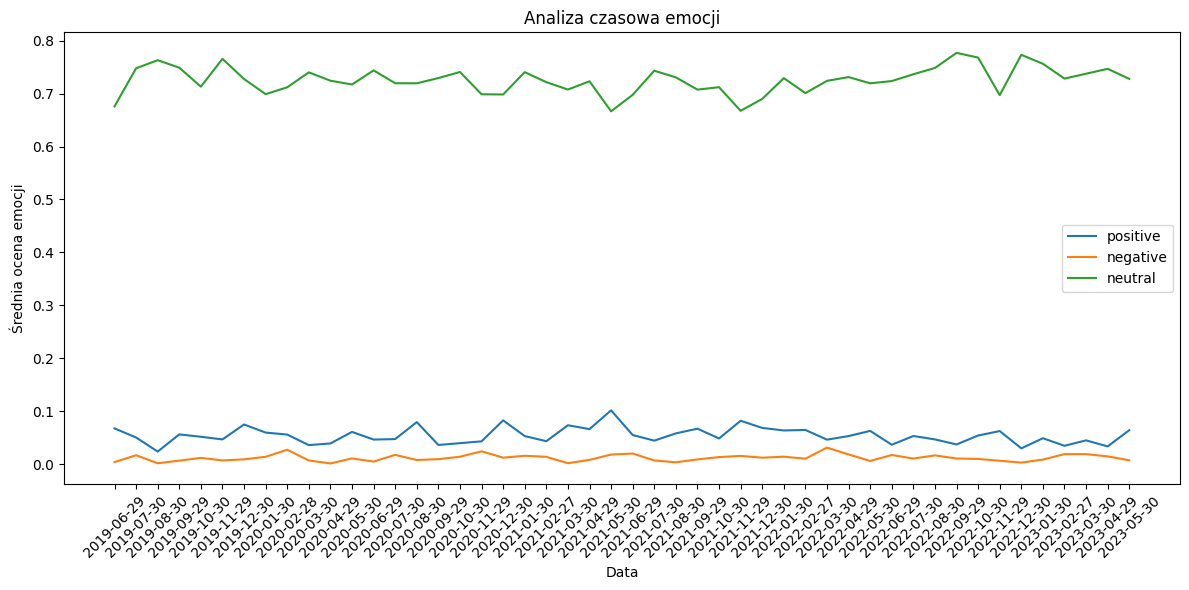

In [34]:
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.sentiment import SentimentIntensityAnalyzer
import csv

emotions = ['positive', 'negative', 'neutral']
progress_interval = 200

dates_emotions = defaultdict(lambda: defaultdict(list))
progress_counter = 0

sia = SentimentIntensityAnalyzer()

tweets = []

with open('preprocessed_tweets.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)

    for row in reader:
        tweet = row['PreprocessedContent']
        date = row['Date']

        tweets.append(tweet)

        sentiment_scores = sia.polarity_scores(tweet)

        print(sentiment_scores)

        if sentiment_scores['pos'] > sentiment_scores['neg'] and sentiment_scores['pos'] > sentiment_scores['neu']:
            dates_emotions[date]['positive'].append(sentiment_scores['pos'])
        else:
            dates_emotions[date]['positive'].append(0)

        if sentiment_scores['neg'] > sentiment_scores['pos'] and sentiment_scores['neg'] > sentiment_scores['neu']:
            dates_emotions[date]['negative'].append(sentiment_scores['neg'])
        else:
            dates_emotions[date]['negative'].append(0)

        dates_emotions[date]['neutral'].append(sentiment_scores['neu'])

        progress_counter += 1
        if progress_counter % progress_interval == 0:
            print(f'Przetworzono emocje dla {progress_counter} tweetów')

dates = list(dates_emotions.keys())

plt.figure(figsize=(12, 6))

for emotion in emotions:
    averaged_emotions = []
    for date in dates:
        scores = dates_emotions[date][emotion]
        if scores:
            averaged_emotions.append(sum(scores) / len(scores))
        else:
            averaged_emotions.append(0)
    plt.plot(dates, averaged_emotions, label=emotion)

plt.xlabel('Data')
plt.ylabel('Średnia ocena emocji')
plt.title('Analiza czasowa emocji')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


<h2 id="podsumowanie">Podsumowanie</h2>

Na analizie całościowej widać wyraźny podział używanych słów pozytywnych i negatywnych. W puli wszystkich tweetów, widać dużo słów neutralnych.

Na analizie czasowej widać dosyć nieregelurany rozkład emocji. Znaczącym momentem jest połowa 2019 roku, wtedy widać olbrzymi skok emocji `happy` oraz spadek `fear`, oraz początek pandemii w 2020 roku, gdzie ogólne emocje znacząco spadły. Dodatkowym wyrożnieniem jest luty 2022 i czerwony wykres `sad` związany z krytyką przez fanów swoich ulubionych drużyn. Wraz ze wzrostem bazy tweetów z większego okresu, można byłoby uzyskać dokładniejsze dane.

<h2 id="bibliografia">Bibliografia</h2>

googleTrans: [https://py-googletrans.readthedocs.io/en/latest/](https://py-googletrans.readthedocs.io/en/latest/)

nltk: [https://www.datacamp.com/tutorial/text-analytics-beginners-nltk](https://www.datacamp.com/tutorial/text-analytics-beginners-nltk)

snscrape: [https://github.com/JustAnotherArchivist/snscrape](https://github.com/JustAnotherArchivist/snscrape)

text2emotion: [https://towardsdatascience.com/text2emotion-python-package-to-detect-emotions-from-textual-data-b2e7b7ce1153](https://towardsdatascience.com/text2emotion-python-package-to-detect-emotions-from-textual-data-b2e7b7ce1153)

wordcloud: [https://www.datacamp.com/tutorial/wordcloud-python](https://www.datacamp.com/tutorial/wordcloud-python)
